## 3️⃣ Statistical Inference & Feature Engineering
<!-- **designed by:** [datamover.ai](https://www.datamover.ai) -->

                                           Step 1: Understanding of data  
                                                    
* Within the train dataset, there are two main dimensions of data has been offered to predict house prices: 

    * 1. House size: Area, Room variables may give indication, although they may not always in the same direction <br>
    (e.g., 1 room flat can be extremely large as 258 unit size), it might be useful to create a area to room ratio varible to account for this via feature engineering <br>
<br> 

        - Given Room is a discrete variable, it can also be transformed into categorical variable to account for different needs of customers, i.e., by 1-3 rooms, and 4+ (corresponding to family house, luxury houses). Although this may lead to missing of information, I computed this variable to further explore its relationship with target variable
<br> 
<br>
    * 2. Geographic location: Address, Zip, Lon, Lat

        - Address, Zip variable can be manipulated, to format these variables into meaningful columns.

       - Zip, Lon, Lat can join on map data with geopandas to extract information whether houses are in city centre or not;
        or locations of houses by radius distances to centre 


- *Other variables* may be useful for predicting house prices (however, requires data collection from external sources), some can be included later:
    
    - [Economical factors](https://cepr.org/voxeu/columns/what-drives-house-prices-lessons-literature): population & income per area/state, supply conditions (e.g., year built)
    - Transportation & surrounding facilities such as education/entertainment resources (yelp, google map)
    - Risk of houses from flood etc 
    - further information about houses (e.g., garden etc)
    <!-- - Housing price across time (forecasting) -->
<!-- * Additionally, one can also perform [spatial regression](https://www.emilyburchfield.org/courses/gsa/spatial_regression_lab) to capture the relationship between predictor and outcome variables at county level  -->

                                          Step 2:  Generated Hypothesis


- ***H1***: Both house size and geographic location would impact house prices 

    * ***H1a***: Area positively associates with house prices -> supported 

    * ***H1b***: There are significant differences in prices between various type of houses (family vs.luxury houses) -> not supported 

    * ***H1c***: Houses located in city center have a higher price -> supported (negative relationship between distance to centre and log_price)


                                        Step 3: Modelling consideration  


- When performing multiple linear regression, we usually are interested in answering several questions, such as: 
    
    1. Is at least one of the predictors x1, x2, ...xn useful in predicting the responses? (p-value of individual predictor)

    2. Do all predictors help to explain y, or is only the subset of predictors useful? (checking multicollinearity facilitates variable choice in the model)
    
    3. How well the model fit the data? (model itself- Adjusted R2; model fit when comparing various model-AIC, BIC)
<!-- 4. Given a set of predictor values, what response value should we predict, and how accurate is our prediction? -->

In [1]:
import warnings

# Load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy as sp
from IPython.display import display
from yellowbrick.base import Visualizer
import geopy.distance
import pyarrow as pa
import fastparquet as fp
import os

# set random seed
np.random.seed(42)

**1. Start the analysis by processing the training dataset based on the findings obtained in the Exploratory Data Analysis (EDA), e.g., by dealing with missing values and removing duplicates if necessary;**
- 💁‍♂️ Try to tailor the [datatype](https://pandas.pydata.org/docs/user_guide/basics.html#basics-dtypes) as much as possible.

In [2]:
# Load data: 
df_train = pd.read_csv("./data/data_train.csv")


In [3]:
#Remove NA and duplicates: 

# Given EDA showed only 0.03% missing values derived from target variable, and no duplicates detected
# It is safe to directly drop them from training sets 
df_train_cleaned = df_train.dropna().drop_duplicates() 
df_train_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 552 entries, 0 to 553
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Price    552 non-null    float64
 1   Address  552 non-null    object 
 2   Zip      552 non-null    object 
 3   Area     552 non-null    int64  
 4   Room     552 non-null    int64  
 5   Lon      552 non-null    float64
 6   Lat      552 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 34.5+ KB


In [4]:
df_train_cleaned.describe()

,Price,Area,Room,Lon,Lat
count,5.520000e+02,552.000000,552.000000,552.000000,552.000000
mean,6.112007e+05,94.702899,3.528986,4.886900,52.363616
std,5.167530e+05,55.149085,1.521495,0.052977,0.023604
min,1.750000e+05,21.000000,1.000000,4.655161,52.291672
25%,3.500000e+05,60.000000,3.000000,4.853715,52.352435
50%,4.620000e+05,82.000000,3.000000,4.887183,52.363825
75%,6.950000e+05,111.000000,4.000000,4.920677,52.377863
max,5.950000e+06,497.000000,14.000000,5.029122,52.423805


In [5]:
# Given exploratory analysis suggested several variables were right skewed,
# more importantly some variables are not at same scale,  
# suggesting need of log transformation, I first transformed these variables 

df_train_cleaned[['log_price', 'log_area']] = np.log(df_train_cleaned[['Price', 'Area']])

# additionally computed price per unit, as economically it might be more sensible to compare unit price
# (however same city may not be necessary)
df_train_cleaned['Price_m²']= df_train_cleaned['Price']/df_train_cleaned['Area']
df_train_cleaned['log_Price_m²']= np.log(df_train_cleaned['Price_m²'])


In [6]:
# create new column calculate distance to city centre 
# Assuming central station as the heart of city, in this way we can compute each houses distance to center point 

city_centre = (52.3791, 4.9003)  # Assuming Amsterdam Centraal Station as city centre reference point
df_train_cleaned['house_coord'] = list(zip(df_train_cleaned.Lat, df_train_cleaned.Lon))

df_train_cleaned['km_to_centre'] =  df_train_cleaned['house_coord'].apply(lambda x: geopy.distance.geodesic(x, city_centre).km)

In [7]:
df_train_cleaned.drop(columns=['house_coord'], axis=1, inplace=True)
df_train_cleaned.head(3)

,Price,Address,Zip,Area,Room,Lon,Lat,log_price,log_area,Price_m²,log_Price_m²,km_to_centre
0,635000.0,"Niersstraat 35 HS, Amsterdam",1078 VH,81,3,4.894509,52.343016,13.361380,4.394449,7839.506173,8.966931,4.034552
1,400000.0,"Jan van Riebeekstraat 3 1, Amsterdam",1057 ZW,61,2,4.858697,52.370661,12.899220,4.110874,6557.377049,8.788346,2.984845
2,695000.0,"Da Costakade 171 III, Amsterdam",1053 WX,88,3,4.874092,52.367502,13.451667,4.477337,7897.727273,8.974330,2.202596


In [8]:
# extract data from https://maps.amsterdam.nl/, and map train set to 9 boarder boroughs

from shapely.geometry import Point
import requests
import geopandas as gpd

url = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=INDELING_STADSDEEL&THEMA=gebiedsindeling"
gdf_districts = gpd.read_file(requests.get(url).text)


geometry = [Point(xy) for xy in zip(df_train_cleaned.Lon, df_train_cleaned.Lat)]
df_train_cleaned_geo = gpd.GeoDataFrame(df_train_cleaned, geometry=geometry,crs="EPSG:4326")

df_train_cleaned_geo = gpd.sjoin(df_train_cleaned_geo,gdf_districts,  how='inner',op= 'intersects')

df_train_cleaned_geo.rename(columns={'Stadsdeel':'Borough', "index_right":"borough_id"}, inplace= True)

df_train_cleaned_geo.drop(columns=['geometry','Stadsdeelcode','Oppervlakte_m2'], inplace=True)
df_train_cleaned_geo.head(3)

/opt/anaconda3/envs/Anacoda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3472: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,Price,Address,Zip,Area,Room,Lon,Lat,log_price,log_area,Price_m²,log_Price_m²,km_to_centre,borough_id,Borough
0,635000.0,"Niersstraat 35 HS, Amsterdam",1078 VH,81,3,4.894509,52.343016,13.361380,4.394449,7839.506173,8.966931,4.034552,8,Zuid
3,1050000.0,"Koninginneweg 158 4, Amsterdam",1075 EE,119,5,4.860818,52.352776,13.864301,4.779123,8823.529412,9.085177,3.976542,8,Zuid
21,345000.0,"IJselstraat 40 2, Amsterdam",1078 CJ,47,2,4.899374,52.347656,12.751300,3.850148,7340.425532,8.901152,3.499476,8,Zuid


In [9]:
# Display the distribution of train set by borough
house_count_by_borough = pd.DataFrame(df_train_cleaned_geo[['borough_id','Borough']].value_counts())
house_count_by_borough.sort_values(by='borough_id')

,,0
borough_id,Borough,
0,Centrum,85
1,Oost,73
3,Nieuw-West,103
4,Zuidoost,44
5,Noord,65
6,West,103
7,Weesp,1
8,Zuid,77


In [10]:
# recreate house type categorical variable
df_train_cleaned_geo['house_type']=pd.qcut(df_train_cleaned_geo['Room'], q=2,labels=['family_1-3', 'luxury_4+'],precision=0)
df_train_cleaned_geo['house_type'].value_counts()

family_1-3    326
luxury_4+     225
Name: house_type, dtype: int64

In [11]:
# recreate house size categorical variable--> small: (20.0, 68.0], medium: (68.0, 100.0] , large: (100.0, 497.0]
df_train_cleaned_geo['house_size_cat']= pd.qcut(df_train_cleaned_geo['Area'], q=3,labels=['small', 'medium', 'large'], precision=0)
df_train_cleaned_geo['house_size_cat'].value_counts()

small     184
large     184
medium    183
Name: house_size_cat, dtype: int64

In [12]:
df_train_cleaned_geo.head(3)

,Price,Address,Zip,Area,Room,Lon,Lat,log_price,log_area,Price_m²,log_Price_m²,km_to_centre,borough_id,Borough,house_type,house_size_cat
0,635000.0,"Niersstraat 35 HS, Amsterdam",1078 VH,81,3,4.894509,52.343016,13.361380,4.394449,7839.506173,8.966931,4.034552,8,Zuid,family_1-3,medium
3,1050000.0,"Koninginneweg 158 4, Amsterdam",1075 EE,119,5,4.860818,52.352776,13.864301,4.779123,8823.529412,9.085177,3.976542,8,Zuid,luxury_4+,large
21,345000.0,"IJselstraat 40 2, Amsterdam",1078 CJ,47,2,4.899374,52.347656,12.751300,3.850148,7340.425532,8.901152,3.499476,8,Zuid,family_1-3,small


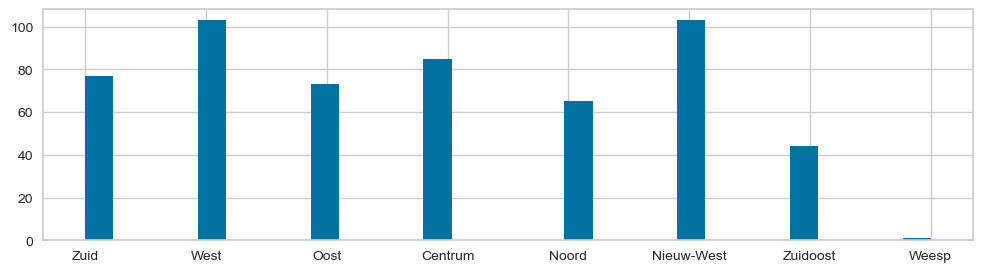

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
df_train_cleaned_geo.Borough.hist( bins = 30,figsize=(12,3))
plt.show()

**2. Study the relationship between variables using conventional statistical tools, namely:** 

- **a.** $\chi^{2}$ ([chi-square](https://www.investopedia.com/terms/c/chi-square-statistic.asp)) between two **Nominal** variables;
- **b.** $\chi^{2}$ or [Spearman’s rank](https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide.php) correlation analysis between two **Ordinal** variables;
- **c.** [Correlation](https://www.statisticshowto.com/probability-and-statistics/correlation-analysis/) analysis for both **Discrete** and **Continuous** variables;
- **d.** An appropriate version of the [t-test](https://www.investopedia.com/terms/t/t-test.asp) or [analysis of variance](https://www.investopedia.com/terms/a/anova.asp) (ANOVA) to assess the relationship between **Numerical** and **Categorical** variables.   

💁‍♀️ Look closely at the relationship between the dependent variable, i.e., the target and the independent variables, i.e., the features, as they will provide an insight into candidate predictors. 

💁‍♂️ Whenever possible, visualize the variables to assess whether the results coming from the statistical test are driven by outliers or imbalanced groups.

👷 Transform and/or construct new features and apply appropriate statistical tests.



**a.** Analysis of **Nominal** features

In [14]:
# Given the above has already transformed the original data frame into various categorical features, 
# I thus categorise the response variables into equal-sized bins using the qcut() function.
df_train_cleaned_geo['Price_range'] = pd.qcut(df_train_cleaned_geo['Price'], q=4, precision=0)
df_train_cleaned_geo['Price_range'].value_counts().sort_index()

(174999.0, 350000.0]     158
(350000.0, 459000.0]     118
(459000.0, 690000.0]     137
(690000.0, 5950000.0]    138
Name: Price_range, dtype: int64

In [15]:
# display(df_train_cleaned_geo.groupby("Price_range")[["log_area", "Room"]].mean())
# display(df_train_cleaned_geo.groupby("Price_range")[["log_area", "Room"]].std())

In [16]:
# generating all contigency tables in excel tabs saving each output 
# By focusing on exploring relationships between similar IVs; as well as each categorical IV with the DV

import openpyxl

# Define each contigency table of interest
contigency_table1 = pd.crosstab(df_train_cleaned_geo['house_type'],df_train_cleaned_geo['house_size_cat']) 
contigency_table2 = pd.crosstab(df_train_cleaned_geo['house_type'],df_train_cleaned_geo['Price_range']) 
contigency_table3 = pd.crosstab(df_train_cleaned_geo['house_size_cat'],df_train_cleaned_geo['Price_range']) 
contigency_table4 = pd.crosstab(df_train_cleaned_geo['Borough'],df_train_cleaned_geo['Price_range']) 

#create a excel writer object that stores each contigency table in a different tab within same file
with pd.ExcelWriter("data/contigency_tables_trainset.xlsx") as writer:
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    contigency_table1.to_excel(writer, sheet_name="Sheet1", index=True)
    contigency_table2.to_excel(writer, sheet_name="Sheet2", index=True)
    contigency_table3.to_excel(writer, sheet_name="Sheet3", index=True)
    contigency_table4.to_excel(writer, sheet_name='Sheet4', index=True)


In [17]:
# Read the excel file just created which contains all the contigency tables
xls = pd.ExcelFile('data/contigency_tables_trainset.xlsx')

#Check list of all sheets in the file
xls.sheet_names

# to read all sheets and store the output into a dictionary, so that later can manipulate these contingeny tables
# from one uniformed data structure 
sheet_to_df_map = {}
for sheet_name in xls.sheet_names:
    sheet_to_df_map[sheet_name] = xls.parse(sheet_name, index_col=0)

# inspect mapped dictionary's data type and display each contigency table from dictionary 
display(list(sheet_to_df_map.values())[0])
display(list(sheet_to_df_map.values())[1])
display(list(sheet_to_df_map.values())[2])
display(list(sheet_to_df_map.values())[3])

,small,medium,large
house_type,,,
family_1-3,175,109,42
luxury_4+,9,74,142


,"(174999.0, 350000.0]","(350000.0, 459000.0]","(459000.0, 690000.0]","(690000.0, 5950000.0]"
house_type,,,,
family_1-3,120,92,74,40
luxury_4+,38,26,63,98


,"(174999.0, 350000.0]","(350000.0, 459000.0]","(459000.0, 690000.0]","(690000.0, 5950000.0]"
house_size_cat,,,,
small,87,73,23,1
medium,67,31,67,18
large,4,14,47,119


,"(174999.0, 350000.0]","(350000.0, 459000.0]","(459000.0, 690000.0]","(690000.0, 5950000.0]"
Borough,,,,
Centrum,7,11,20,47
Nieuw-West,48,24,23,8
Noord,26,6,15,18
Oost,10,23,25,15
Weesp,0,0,1,0
West,26,29,31,17
Zuid,5,19,20,33
Zuidoost,36,6,2,0


In [18]:
# store results output in a dataframe
from scipy.stats import chi2_contingency

# Create empty df to store results from chi-square tests
chi_res = pd.DataFrame(columns=['Statistic','p-value','DoF','Result'])
alpha=0.05

# Looping through each contingency table to perform chi-square test
for i, value in enumerate(sheet_to_df_map):
    c, p, dof, expected_freq = chi2_contingency(list(sheet_to_df_map.values())[i], correction=True)
    if p <= alpha:
        pp = 'Dependent (reject H0)'
    else:
        pp = 'Independent (fail to reject H0)'
    lst = [round(c,2), round(p,4), dof, pp]
    chi_res.loc[len(chi_res)] = lst

# Tidy up final test result table 
chi_res.reset_index(inplace = True)
chi_res.rename(columns = {'index':'Contigency_Table'}, inplace = True)

chi_res['Contigency_Table'].replace({0: "house_type & house_size_cat", 
                                     1: "Price_range & house_type",
                                     2: "Price_range & house_size_cat",
                                     3: " Price_range & Borough"
                                     },inplace=True)

chi_res.set_index('Contigency_Table', inplace = True)
chi_res

,Statistic,p-value,DoF,Result
Contigency_Table,,,,
house_type & house_size_cat,198.97,0.0,2,Dependent (reject H0)
Price_range & house_type,89.22,0.0,3,Dependent (reject H0)
Price_range & house_size_cat,315.92,0.0,6,Dependent (reject H0)
Price_range & Borough,186.70,0.0,21,Dependent (reject H0)


<!-- https://neuhofmo.github.io/chi-square-and-post-hoc-in-python/ -->

- Examined the computed variables derived from area, room, and geolocation; results showed these catgeorical variables were dependent on each other 

**b.** Analysis of **Ordinal** features

* No ordinal features from raw train set, although some of featured ordinal variables has been tested above  

**c.** Analysis of **Discrete** and **Continuous** features

In [19]:
# tidy up and remove columns that were duplicating
res_dat = df_train_cleaned_geo.drop(columns=['Price', 'Area','Price_m²','Address','Zip','Lon','Lat','log_Price_m²','borough_id','Price_range'], axis=1 ) #remove raw data column before log transformation
res_dat.columns

Index(['Room', 'log_price', 'log_area', 'km_to_centre', 'Borough',
       'house_type', 'house_size_cat'],
      dtype='object')

/var/folders/m6/h_c6j54j54723kby9c10j_0m0000gn/T/ipykernel_8650/1786821713.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = res_dat.corr().round(2)


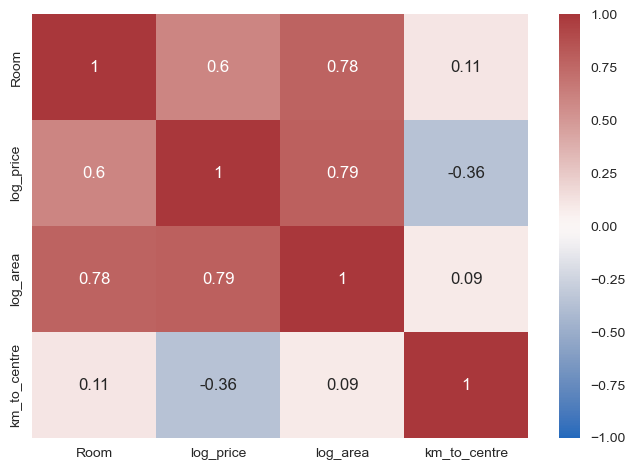

In [20]:
# display(res_dat.corr())

# visualise correlation matrix among variables 
matrix = res_dat.corr().round(2)
# mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')#, mask=mask)
plt.show()

- High correlations between Room and Area variables

- There is also a negative correlation between distance to centre with log_price, indicating the further from city centre is negatively associated to log_price 

In [21]:
#specify predictor and outcomes variables in the model 
y = res_dat["log_price"]
x = res_dat.drop(columns=['log_price'], axis=1 ) 
x.columns


Index(['Room', 'log_area', 'km_to_centre', 'Borough', 'house_type',
       'house_size_cat'],
      dtype='object')

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

numerical = x.select_dtypes([np.int64, np.float64])

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = numerical.columns
vif_data["VIF"] = [variance_inflation_factor(numerical.values, i)
                          for i in range(len(numerical.columns))]

vif_data

,feature,VIF
0,Room,9.520401
1,log_area,12.625907
2,km_to_centre,3.960413


In [23]:
# Evidence supporting H1a, H1c
import statsmodels.formula.api as smf
lm = smf.ols("log_price ~ log_area + Room + km_to_centre", data= res_dat)
model = lm.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     749.5
Date:                Sun, 13 Aug 2023   Prob (F-statistic):          2.91e-193
Time:                        13:16:54   Log-Likelihood:                 8.0772
No. Observations:                 551   AIC:                            -8.154
Df Residuals:                     547   BIC:                             9.093
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        9.4839      0.123     76.864   

In [24]:
# Reject H1b 
import statsmodels.formula.api as smf
lm = smf.ols("log_price ~ log_area + house_type + km_to_centre", data= res_dat)
model = lm.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     752.0
Date:                Sun, 13 Aug 2023   Prob (F-statistic):          1.38e-193
Time:                        13:16:54   Log-Likelihood:                 8.8253
No. Observations:                 551   AIC:                            -9.651
Df Residuals:                     547   BIC:                             7.596
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

- VIF detects multicollinearity in regression analysis. when including all numeric varibles in the cleaned train set, room and log_area has been all above thredsholds (i.e., >5)

- In the above regression, room is not statistically significant, and given it is highly correlated with log_area, I thus remove this variable from the model. After removing it, the vif score indicated that no multicollinearity has been detected 

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

numerical = x[['log_area','km_to_centre']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = numerical.columns
vif_data["VIF"] = [variance_inflation_factor(numerical.values, i)
                          for i in range(len(numerical.columns))]

vif_data

,feature,VIF
0,log_area,3.959582
1,km_to_centre,3.959582


In [26]:
res_dat.columns

Index(['Room', 'log_price', 'log_area', 'km_to_centre', 'Borough',
       'house_type', 'house_size_cat'],
      dtype='object')

In [27]:
# Final model selection 
import statsmodels.formula.api as smf
# lm = smf.ols("log_price ~  km_to_centre+ log_area", data= res_dat)

lm = smf.ols("log_price ~  km_to_centre+ log_area +Borough", data= res_dat)
model = lm.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     407.6
Date:                Sun, 13 Aug 2023   Prob (F-statistic):          1.67e-234
Time:                        13:16:54   Log-Likelihood:                 123.91
No. Observations:                 551   AIC:                            -227.8
Df Residuals:                     541   BIC:                            -184.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 9.40

- Also tried with mixed effects model with random intercept as below to explore different level of price across boroughs. Results showed not the case  

In [28]:
# boxplot = res_dat.boxplot(["log_price"], by = ["Borough"],
#                      figsize = (16, 9),
#                      showmeans = True,
#                      notch = True)

# boxplot.set_xlabel("Borough")
# boxplot.set_ylabel("log_price")
# boxplot.set_title('Avg log price by Borough')

In [29]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf

# md = smf.mixedlm("log_price ~  log_area + km_to_centre +C(Borough)", res_dat, 
#                  groups=res_dat["Borough"])
# mdf = md.fit()
# print(mdf.summary())

**3. Identify outliers and points of high leverage and re-run statistical tests to assess their impact.** 

Checked this [article](https://online.stat.psu.edu/stat462/node/170/#:~:text=In%20short%3A,is%20particularly%20high%20or%20low.) to understand the difference between **outliers** and **high-leverage points**.

- [Cook's distance](https://rpubs.com/DragonflyStats/Cooks-Distance) is a commonly used estimate of the influence of a data point when performing least squares regression analysis. Below section relied on Cook's distance method to detect influential cases. 

<!-- (https://towardsdatascience.com/identifying-outliers-in-linear-regression-cooks-distance-9e212e9136a#:~:text=Cook's%20Distance%20is%20an%20estimate,the%20ith%20observation%20is%20removed.) -->


In [30]:
res_dat.columns

Index(['Room', 'log_price', 'log_area', 'km_to_centre', 'Borough',
       'house_type', 'house_size_cat'],
      dtype='object')

Index(['Room', 'log_price', 'log_area', 'km_to_centre'], dtype='object')


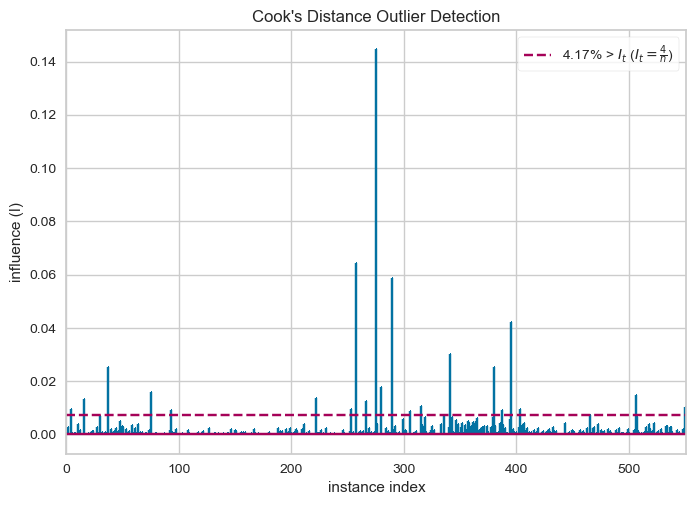

<Axes: title={'center': "Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [31]:
# https://lymielynn.medium.com/a-little-closer-to-cooks-distance-e8cc923a3250
# https://stackoverflow.com/questions/51390196/how-to-calculate-cooks-distance-dffits-using-python-statsmodel 
# https://www.scikit-yb.org/en/latest/_modules/yellowbrick/regressor/influence.html?highlight=cook%27s%20distance

from yellowbrick.regressor import CooksDistance

df_num = res_dat.select_dtypes([int, float])
# df_num = df_num.drop(columns=["Room"], axis= 1)

X = df_num.drop(columns=["log_price"],axis=1)
y = res_dat['log_price']

visualizer = CooksDistance()
visualizer.fit(X, y)

print(df_num.columns)
visualizer.show()



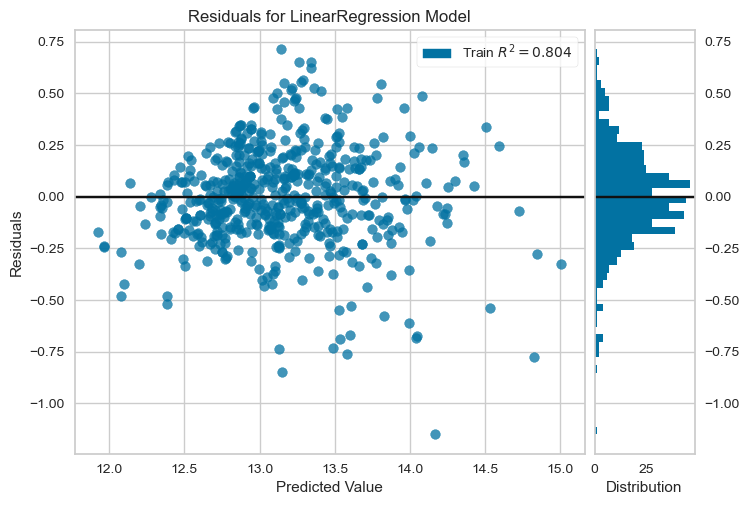

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [32]:
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot

model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X, y)
visualizer_residuals.show()

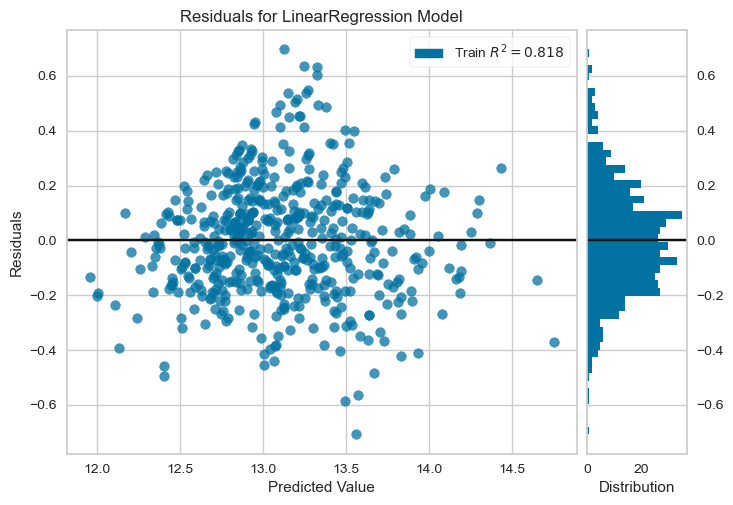

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [33]:
i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
X_li, y_li = X[i_less_influential], y[i_less_influential]

model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X_li, y_li)
visualizer_residuals.show()

In [34]:
# Display influential cases 
df_train_cleaned_geo['influential'] = (visualizer.distance_ > visualizer.influence_threshold_)
df_train_cleaned_geo['infl_distance']=visualizer.distance_

print(f"There are {len(df_train_cleaned_geo[df_train_cleaned_geo['influential']==True])} influential cases detected from train set")

df_influential = df_train_cleaned_geo[df_train_cleaned_geo['influential']==True].sort_values(by='infl_distance', ascending= False)

display(df_influential.sample(3))


There are 23 influential cases detected from train set


,Price,Address,Zip,Area,Room,Lon,Lat,log_price,log_area,Price_m²,log_Price_m²,km_to_centre,borough_id,Borough,house_type,house_size_cat,Price_range,influential,infl_distance
9,285000.0,"Laan van Vlaanderen 141 A2, Amsterdam",1066 MP,37,2,4.807805,52.344914,12.560244,3.610918,7702.702703,8.949327,7.360246,3,Nieuw-West,family_1-3,small,"(174999.0, 350000.0]",True,0.009653
11,350000.0,"Haag en Veld 245 B, Amsterdam",1102 GL,144,6,4.955915,52.310514,12.765688,4.969813,2430.555556,7.795875,8.521138,4,Zuidoost,luxury_4+,large,"(174999.0, 350000.0]",True,0.014766
145,5950000.0,"Keizersgracht 544, Amsterdam",1017 EL,394,10,4.887378,52.365078,15.598902,5.976351,15101.522843,9.622551,1.791381,0,Centrum,luxury_4+,large,"(690000.0, 5950000.0]",True,0.144563


- Cook's distance results indicated that removal of influential cases does not have a significant impact on the model

- See this [link](https://towardsdatascience.com/are-you-using-feature-distributions-to-detect-outliers-48e2ae3309) for other ways detecting influential cases 

**5. If new features are created, save a new dataframe, ideally in [parquet](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_parquet.html) format, to retain metadata information.**

💁‍♂️ If you also have the validation set, apply the same transformations and save an additional dataframe.

ℹ️ `DataFrame.to_parquet()` requires [pyarrow](https://pypi.org/project/pyarrow/) and [fastparquet](https://pypi.org/project/fastparquet/) libraries.

In [35]:
import pyarrow as pa
import pyarrow.parquet as pq
import fastparquet as fp
import platform

print('Python: ', platform.python_version())
print('pandas: ', pd.__version__)
print('pyarrow: ', pa.__version__)


Python:  3.10.8
pandas:  1.5.3
pyarrow:  12.0.1


In [36]:
# store transformed data into parquet file
res_dat.to_parquet('data/transformed_train_set.parquet.gzip', compression='gzip')

In [37]:
import pyarrow.parquet as pq
import os

DATA_DIR = "data"
FILENAME = "transformed_train_set.parquet.gzip"

# Extract transformed_train_set.parquet.gzip
transformed_train_set = pd.read_parquet(
                                        os.path.join(DATA_DIR, FILENAME),
                                        engine='pyarrow')

transformed_train_set.head(3)

,Room,log_price,log_area,km_to_centre,Borough,house_type,house_size_cat
0,3,13.361380,4.394449,4.034552,Zuid,family_1-3,medium
3,5,13.864301,4.779123,3.976542,Zuid,luxury_4+,large
21,2,12.751300,3.850148,3.499476,Zuid,family_1-3,small


In [38]:
# Overwrite table schema for the feature engineered training set with customised specifications

transformed_train_set_schema = pa.schema([
     pa.field("Room", pa.int64(), metadata={"Description": "Number of rooms at residence, 1-14",
                                            "Calculation": "No",
                                            "Method": "Used as it is from source",
                                            "Data lineage": "data_train.csv",
                                            "Value": "1 to 14"
                                        }),
     
     pa.field("log_price", pa.float64(), metadata={"Description": "Transformed residential price in Euros from y to log(y)",
                                                  "Calculation": "Yes",
                                                  "Method": "log(y)",
                                                  "Data lineage": "data_train.csv",
                                                  "Value": "log(1.750000e+05) to log(5.950000e+06)"
                                               }),
     
     pa.field("log_area", pa.float64(), metadata={"Description": "Transformed residential area in square meters from x to log(x)",
                                                  "Calculation": "Yes",
                                                  "Method": "log(x)",
                                                  "Data lineage": "data_train.csv",
                                                  "Value": "log(21) to log(497)"
                                              }),
     
     pa.field("km_to_centre", pa.float64(), metadata={"Description":"Distance in kilometers from residence to Amsterdam Centraal Station\
                                                      (point reference proxy for city centre)",
                                                      "Calculation": "Yes",
                                                      "Method": "geopy.distance.geodesic by coordinates(Lat,Lon) and (52.379189, 4.899431)",
                                                      "Data lineage": "data_train.csv",
                                                      "Value": "0.35 to 11.39"
                                                  }),
     
     pa.field("Borough", pa.string(), metadata={"Description":"Amsterdam borough where residence is located",
                                                "Calculation": "Yes",
                                                "Method": "GeoPandas.sjoin by coordinates (Lon,Lat) and geometry",
                                                "Data lineage": "https://maps.amsterdam.nl/open_geodata/ -> Stadsdelen.shp",
                                                "Value": "Centrum, Oost, Nieuw-West, Zuidoost, Noord, West, Weesp, Zuid"
                                              }),
     
     pa.field("house_type", pa.string(),  metadata={"Description": "Type of residence base on number of rooms",
                                                    "Calculation": "No",
                                                    "Method": "Manual, qcut based on room count",
                                                    "Data lineage": "data_train.csv",
                                                    "Value": "'family_1-3'(326),'luxury_4+'(225)"
                                                    }),                                                
     
     pa.field("house_size_cat", pa.string(),  metadata={"Description": "Categorisation of house size based on Area (raw square meters)",
                                                        "Calculation": "No",
                                                        "Method": "Manual, qcut based on Area",
                                                        "Data lineage": "data_train.csv",
                                                        "Value": " 'Small'(184)->(20.0, 67.0], 'Medium'(183)->(67.0, 90.0],\
                                                        'Large'(184)->(90.0, 497.0]"})
     ],     
                                         
     metadata={"Dataset Description": "Feature engineered training set for baseline model building", 
               "Dataset Name": "Amsterdam House Price Prediction feature engineered training set",
               "Data lineage": "R3_statistical_inference.ipynb",
               "Data source": "https://www.kaggle.com/datasets/thomasnibb/amsterdam-house-price-prediction"
            }
)


In [39]:
# Read customised table schema from transformed_train_set.parquet.gzip 
print(transformed_train_set_schema)

Room: int64
  -- field metadata --
  Description: 'Number of rooms at residence, 1-14'
  Calculation: 'No'
  Method: 'Used as it is from source'
  Data lineage: 'data_train.csv'
  Value: '1 to 14'
log_price: double
  -- field metadata --
  Description: 'Transformed residential price in Euros from y to log(y)'
  Calculation: 'Yes'
  Method: 'log(y)'
  Data lineage: 'data_train.csv'
  Value: 'log(1.750000e+05) to log(5.950000e+06)'
log_area: double
  -- field metadata --
  Description: 'Transformed residential area in square meters from x to l' + 5
  Calculation: 'Yes'
  Method: 'log(x)'
  Data lineage: 'data_train.csv'
  Value: 'log(21) to log(497)'
km_to_centre: double
  -- field metadata --
  Description: 'Distance in kilometers from residence to Amsterdam Centra' + 103
  Calculation: 'Yes'
  Method: 'geopy.distance.geodesic by coordinates(Lat,Lon) and (52.379189' + 11
  Data lineage: 'data_train.csv'
  Value: '0.35 to 11.39'
Borough: string
  -- field metadata --
  Description: 'Amst

**5. Generate a summary report. Below are a few bullet points you can reference:**
<!-- - **a.** Annotate the candidate features that have shown a meaningful relationship with the target;
- **b.** Mention any significant relationships between features that can lead to multicollinearity issues;
- **c.** Eventual outliers and points of high leverage and their impact;
- **d.** Anything else that is noteworthy for model training. -->


- **a.** Annotate the candidate features that have shown a meaningful relationship with the target;

    - log area is positively correlated with log price, whereas km_to_centre has a moderate negative correlation with log price 



- **b.** Mention any significant relationships between features that can lead to multicollinearity issues;

    - Variance inflation factor (VIF) test revealed potential multicollinarity between log area and room  

- **c.** Eventual outliers and points of high leverage and their impact;

    - Cook's distance results indicated that removal of influential cases does not have a significant impact on the model

- **d.** Anything else that is noteworthy for model training.

    - Results are fairly consistent across train and validation sets. 

    - One caveat from current feature engineering attempt: 
    
        - Relying on qcut to transform 'Area' and 'Room' into categorical variables may not be ideal, given those range intervals seems to change slightly across datasets. Although these variables seems not important for model training. <br>
<br>
    - Currently the best performing model is (Adjusted R^2 =.869):
    
            log(Price) = β0 + β1kmtocentre + β2log(Area) + β2 Borough + ε



    <!-- $$\text{log(Price)} = \beta0 +\beta1\text{kmtocentre} + \beta2\text{log(Area)} + \beta3\text{Borough}+ \varepsilon$$  -->


